Required packets

In [1]:
from darts import TimeSeries
from darts.metrics import mape, mse, mae
from darts.models import NaiveMean, NaiveSeasonal, NaiveDrift, NaiveMovingAverage, RandomForest, LinearRegressionModel, AutoARIMA, Theta, StatsForecastAutoETS, Prophet, NBEATSModel, NLinearModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
import sklearn
from sklearn import preprocessing
from darts.timeseries import concatenate

/home/filo/University/Thesis/Algorithm/wav_env/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


Load dataset as a series and prepare it by splitting into train and test

Dataset contains NaN values


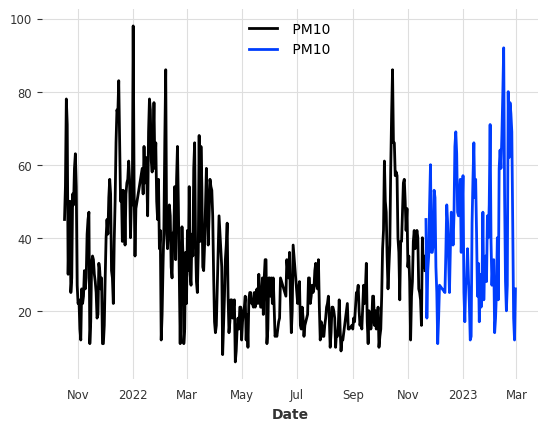

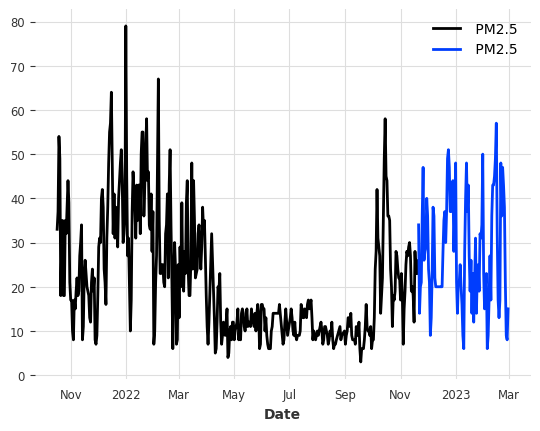

In [ ]:
df = pd.read_csv("../dataset/ARPA/ARPA.csv", header=0, index_col=0)
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
df.index.name = 'Date'
# Check for NaN values
nan_check = df.isna().any().any()

if nan_check:
    print("Dataset contains NaN values")
    upsampled= df.resample('D').mean()
    series = upsampled.interpolate(method = 'linear')
else:
    print("Dataset does not contain NaN values")
series = TimeSeries.from_dataframe(series)
train, test = series.split_after(0.80)
if series.is_univariate:
  train.plot()
  test.plot()
else:
  header = train.columns
  for column in header:
    try:
      train[column].plot()
      test[column].plot()
      plt.show()
    except KeyError as e:
      print(e)


df = pd.read_csv("../Dataset Preparation/ PM10.csv", header=0, index_col=0)
df.index = pd.to_datetime(df.index)
series_10 = TimeSeries.from_dataframe(df, time_col=0)
train_10, test_10 = series_10.split_after(0.75)

df = pd.read_csv("../Dataset Preparation/ PM2.5.csv", header=0, index_col=0)
df.index = pd.to_datetime(df.index)
series_25 = TimeSeries.from_dataframe(df, time_col=0)
train_25, test_25 = series_25.split_after(0.75)

Create a list of time series obj slicing the dataset into parts identified with wavelet

In [ ]:
df = pd.read_csv("../Dataset Preparation/final_dataset.csv", header=0, index_col=0)
df.index = pd.to_datetime(df.index)
series = TimeSeries.from_dataframe(df, time_col=0)
time_index = series.time_index
header = series.columns
lst_series = []
for column in header:
    tmp_series = series.univariate_component(column).values()
    start_index = 1
    for i in range(0, len(series)-1):
        if np.isnan(tmp_series[i]) and np.isnan(tmp_series[i+1]) == False:
            start_index = i + 1
        if np.isnan(tmp_series[i]) == False and np.isnan(tmp_series[i+1]) and start_index != 0:
            end_index = i
            if end_index - start_index > 24:
                res = series.univariate_component(column).slice(start_ts=time_index[start_index], end_ts=time_index[end_index])
                lst_series.append(res)
            start_index = 0  

In [47]:
print(lst_series)

[<TimeSeries (DataArray) (Data/Ora: 79, component: 1, sample: 1)> Size: 632B
array([[[54.]],

       [[78.]],

       [[71.]],

       [[30.]],

       [[43.]],

       [[50.]],

       [[25.]],

       [[29.]],

       [[52.]],

       [[49.]],

...

       [[56.]],

       [[61.]],

       [[56.]],

       [[40.]],

       [[50.]],

       [[49.]],

       [[98.]],

       [[54.]],

       [[35.]],

       [[48.]]])
Coordinates:
  * Data/Ora   (Data/Ora) datetime64[ns] 632B 2021-10-18 ... 2022-01-04
  * component  (component) object 8B ' PM10'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None, <TimeSeries (DataArray) (Data/Ora: 83, component: 1, sample: 1)> Size: 664B
array([[[59.]],

       [[52.]],

       [[65.]],

       [[55.]],

       [[62.]],

       [[57.]],

       [[46.]],

       [[69.]],

       [[78.]],

       [[75.]],

...

       [[38.]],

       [[46.]],

       [[56.]],

       [[54.]],

       [[53.]],

  

## Naive Models - Baseline

In [ ]:
model0 = NaiveMean()
model1 = NaiveSeasonal(K = 24)
model2 = NaiveDrift()
model3 = NaiveMovingAverage(input_chunk_length = 24)

models = {
    "Mean": model0,
    "Seasonal": model1,
    "Drift": model2,
    "MA": model3
}

In [ ]:
fig = plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items()):
  print(name)
  model.fit(series=train)
  predictions = model.predict(n = len(test))
  mae_score = round(mae(test, predictions), 2)
  mse_score = round(mse(test, predictions), 2)

  fig.add_subplot(2, 2, i+1)
  train.plot(label="train"); test.plot(label="test"); predictions.plot(label=name)
  plt.title(f"Method: {name}, MAE: {mae_score}, MSE: {mse_score} with sample selection"); plt.legend()
fig.tight_layout()
plt.show()

## Classical Models

In [ ]:
model0 = Theta()
model1 = LinearRegressionModel(lags=24)
model2 = StatsForecastAutoETS()
model3 = AutoARIMA(start_p=2, max_p=12, start_q=1)
model4 = RandomForest(lags=24, n_estimators=300)
model5 = Prophet()

models = {
    "Theta": model0,
    "Linear": model1,
    "Exponential": model2,
    "ARIMA": model3,
    "RandomForest": model4,
    "Prophet": model5
}

### FIT - PREDICT

In [ ]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 12))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    print(column)
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    model.fit(series=tmp_train)
    predictions = model.predict(n = len(tmp_test))
    mae_score = round(mae(tmp_test, predictions), 5)
    mae_list.append([mae_score, name, column, 'std'])
    mse_score = round(mse(tmp_test, predictions), 5)
    mse_list.append([mse_score, name, column, 'std'])

    index += i + row
    fig.add_subplot(6, 2, index) #method, variable, position
    tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} (std)")
fig.tight_layout()
plt.savefig('w_o.png')
plt.show()

fig = plt.figure(figsize=(18, 12))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    if column == ' PM10':
      model.fit(series=train_10)
      predictions = model.predict(n = len(test))
      mae_score = round(mae(test_10, predictions), 5)
      mae_list.append([mae_score, name, column, 'PM10'])
      mse_score = round(mse(test_10, predictions), 5)
      mse_list.append([mse_score, name, column, 'PM10'])
    elif column == ' PM2.5':
      model.fit(series=train_25)
      predictions = model.predict(n = len(test))
      mae_score = round(mae(test_25, predictions), 5)
      mae_list.append([mae_score, name, column, 'PM25'])
      mse_score = round(mse(test_25, predictions), 5)
      mse_list.append([mse_score, name, column, 'PM25'])
    index += i + row
    fig.add_subplot(6, 2, index)
    
    if column == ' PM10':
      print(column)
      train_10.plot(label="train"); test_10.plot(label="test"); predictions.plot(label=name)
    elif column == ' PM2.5':
      print(column)
      train_25.plot(label="train"); test_25.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with selection");
fig.tight_layout()
plt.savefig('w.png')
plt.show()

In [ ]:
print(mae_list)
print(mse_list)

### BACKTEST

Backtest 

In [ ]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 12))
row = 0

for i, (name, model) in enumerate(models.items()):
    print(name)
    row += 1

    for index, column in enumerate(header):
        print(f'Column name: {column}')
        tmp_series = series.univariate_component(column)
        tmp_train = train.univariate_component(column)
        tmp_test = test.univariate_component(column)
        
        # Get predictions
        prediction = model.historical_forecasts(series=tmp_series,
                                                  start=len(tmp_train),
                                                  forecast_horizon=len(tmp_test),
                                                  stride=1,
                                                  retrain=True,
                                                  last_points_only=False)

        predictions = concatenate(prediction)
        # Calculate MAE and MSE
        mae_score = round(mae(tmp_test, predictions), 5)
        mae_list.append([mae_score, name, column, 'std'])
        mse_score = round(mse(tmp_test, predictions), 5)
        mse_list.append([mse_score, name, column, 'std'])

        index += i + row
        fig.add_subplot(6, 2, index)  # method, variable, position
        tmp_train.plot(label="train")
        tmp_test.plot(label="test")
        predictions.plot(label=name)
        plt.title(f"Method: {name}, Variable: {column} (std)")
        

fig.tight_layout()
plt.savefig('w_o.png')
plt.show()


fig = plt.figure(figsize=(18, 12))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  
  for index, column in enumerate(header):
    if column == ' PM10':
      tmp_series = series_10.univariate_component(column)
      forecast_len = len(test)
      
      prediction = model.historical_forecasts(series=tmp_series,
                                                start = len(train_10),
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      end = len(train_10) + len(test)
      mae_score = round(mae(tmp_series[len(train_10):end], predictions), 5)
      mae_list.append([mae_score, name, column, 'PM10'])
      mse_score = round(mse(tmp_series[len(train_10):end], predictions), 5)
      mse_list.append([mse_score, name, column, 'PM10'])
    elif column == ' PM2.5':
      tmp_series = series_25.univariate_component(column)
      forecast_len = len(test)
      print(forecast_len)
      print(len(series_25))
      prediction = model.historical_forecasts(series=tmp_series,
                                                start = len(train_25),
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      end = len(train_25) + len(test)
      mae_score = round(mae(tmp_series[len(train_25):end], predictions), 5)
      mae_list.append([mae_score, name, column, 'PM25'])
      mse_score = round(mse(tmp_series[len(train_25):end], predictions), 5)
      mse_list.append([mse_score, name, column, 'PM25'])
    index += i + row
    fig.add_subplot(6, 2, index)
    
    if column == ' PM10':
      print(column)
      train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
    elif column == ' PM2.5':
      print(column)
      train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with selection");
fig.tight_layout()
plt.savefig('w.png')
plt.show()

Backtest with second try

In [ ]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 12))
row = 0

for i, (name, model) in enumerate(models.items()):
    print(name)
    row += 1

    for index, column in enumerate(header):
        print(f'Column name: {column}')
        tmp_series = series.univariate_component(column)
        tmp_train = train.univariate_component(column)
        tmp_test = test.univariate_component(column)
        print(len(tmp_test))
        print(f'Length of train: {len(tmp_train)}')
        
        # Get predictions
        prediction = model.historical_forecasts(series=tmp_series,
                                                  start=len(tmp_train),
                                                  forecast_horizon=len(tmp_test),
                                                  stride=1,
                                                  retrain=True,
                                                  last_points_only=False)

        predictions = concatenate(prediction)
        print(len(predictions))
        # Calculate MAE and MSE
        mae_score = round(mae(tmp_test, predictions), 5)
        mae_list.append([mae_score, name, column, 'std'])
        mse_score = round(mse(tmp_test, predictions), 5)
        mse_list.append([mse_score, name, column, 'std'])

        index += i + row
        fig.add_subplot(6, 2, index)  # method, variable, position
        tmp_train.plot(label="train")
        tmp_test.plot(label="test")
        predictions.plot(label=name)
        plt.title(f"Method: {name}, Variable: {column} (std)")
        

fig.tight_layout()
plt.savefig('w_o.png')
plt.show()


fig = plt.figure(figsize=(18, 12))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  
  for index, column in enumerate(header):
    if column == ' PM10':
      tmp_series = series_10.univariate_component(column)
      forecast_len = len(series)-len(train_10)
      
      prediction = model.historical_forecasts(series=tmp_series,
                                                start = len(train_10),
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      tmp_series = series.univariate_component(column)
      mae_score = round(mae(tmp_series[len(train_10):], predictions), 5)
      mae_list.append([mae_score, name, column, 'PM10'])
      mse_score = round(mse(tmp_series[len(train_10):], predictions), 5)
      mse_list.append([mse_score, name, column, 'PM10'])
    elif column == ' PM2.5':
      tmp_series = series_25.univariate_component(column)
      forecast_len = len(series)-len(train_25)
      
      prediction = model.historical_forecasts(series=tmp_series,
                                                start = len(train_25),
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      mae_score = round(mae(tmp_series[len(train_25):], predictions), 5)
      mae_list.append([mae_score, name, column, 'PM25'])
      mse_score = round(mse(tmp_series[len(train_25):], predictions), 5)
      mse_list.append([mse_score, name, column, 'PM25'])
    index += i + row
    fig.add_subplot(6, 2, index)
    
    if column == ' PM10':
      print(column)
      train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
    elif column == ' PM2.5':
      print(column)
      train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with selection");
fig.tight_layout()
plt.savefig('w.png')
plt.show()

In [ ]:
print(mae_list)
print(mse_list)

## Deep Learning models

In [51]:
model6 = NBEATSModel(
    input_chunk_length = 7,
    output_chunk_length= 2,
    num_stacks = 3,
    num_blocks = 2,
    num_layers = 3,
    layer_widths = 32,
    n_epochs = 150,
    batch_size = 12,
)

model7 = NLinearModel(
    input_chunk_length=7,
    output_chunk_length=2,
    n_epochs= 150,
)

models = {
    "NBEATS": model6,
    "NLinear": model7
}

### FIT - PREDICT

Forecast with fit predict

In [52]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 14))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    model.fit(series=tmp_train)
    predictions = model.predict(n = len(test))
    mae_score = round(mae(tmp_test, predictions), 5)
    mae_list.append([mae_score, name, 'std'])
    mse_score = round(mse(tmp_test, predictions), 5)
    mse_list.append([mse_score, name, 'std'])
    index += i + row
    fig.add_subplot(2, 2, index) # method, variable, position
    tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
fig.tight_layout()
plt.savefig('nn_wo.png')
plt.show()

fig = plt.figure(figsize=(16, 10))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    if column == ' PM10':
      model.fit(series=train_10)
      predictions = model.predict(n = len(test))
      mae_score = round(mae(test_10, predictions), 5)
      mae_list.append([mae_score, name, 'PM10'])
      mse_score = round(mse(test_10, predictions), 5)
      mse_list.append([mse_score, name, 'PM10'])
    elif column == ' PM2.5':
      model.fit(series=train_25)
      predictions = model.predict(n = len(test))
      mae_score = round(mae(test_25, predictions), 5)
      mae_list.append([mae_score, name, 'PM25'])
      mse_score = round(mse(test_25, predictions), 5)
      mse_list.append([mse_score, name, 'PM25'])

    index += i + row
    fig.add_subplot(2, 2, index)
    if column == ' PM10':
      train.plot(label="train"); test_10.plot(label="test"); predictions.plot(label=name)
    elif column == ' PM2.5':
      train.plot(label="train"); test_25.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('nn_w.png')
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


NBEATS


Training: |          | 0/? [00:00<?, ?it/s]

/home/filo/University/Thesis/Algorithm/wav_env/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(mae_list)
print(mse_list)

Training with a list of time series

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


NBEATS


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.5 K
---------------------------------------------------
16.3 K    Trainable params
207       Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


NLinear


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 16    
---------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

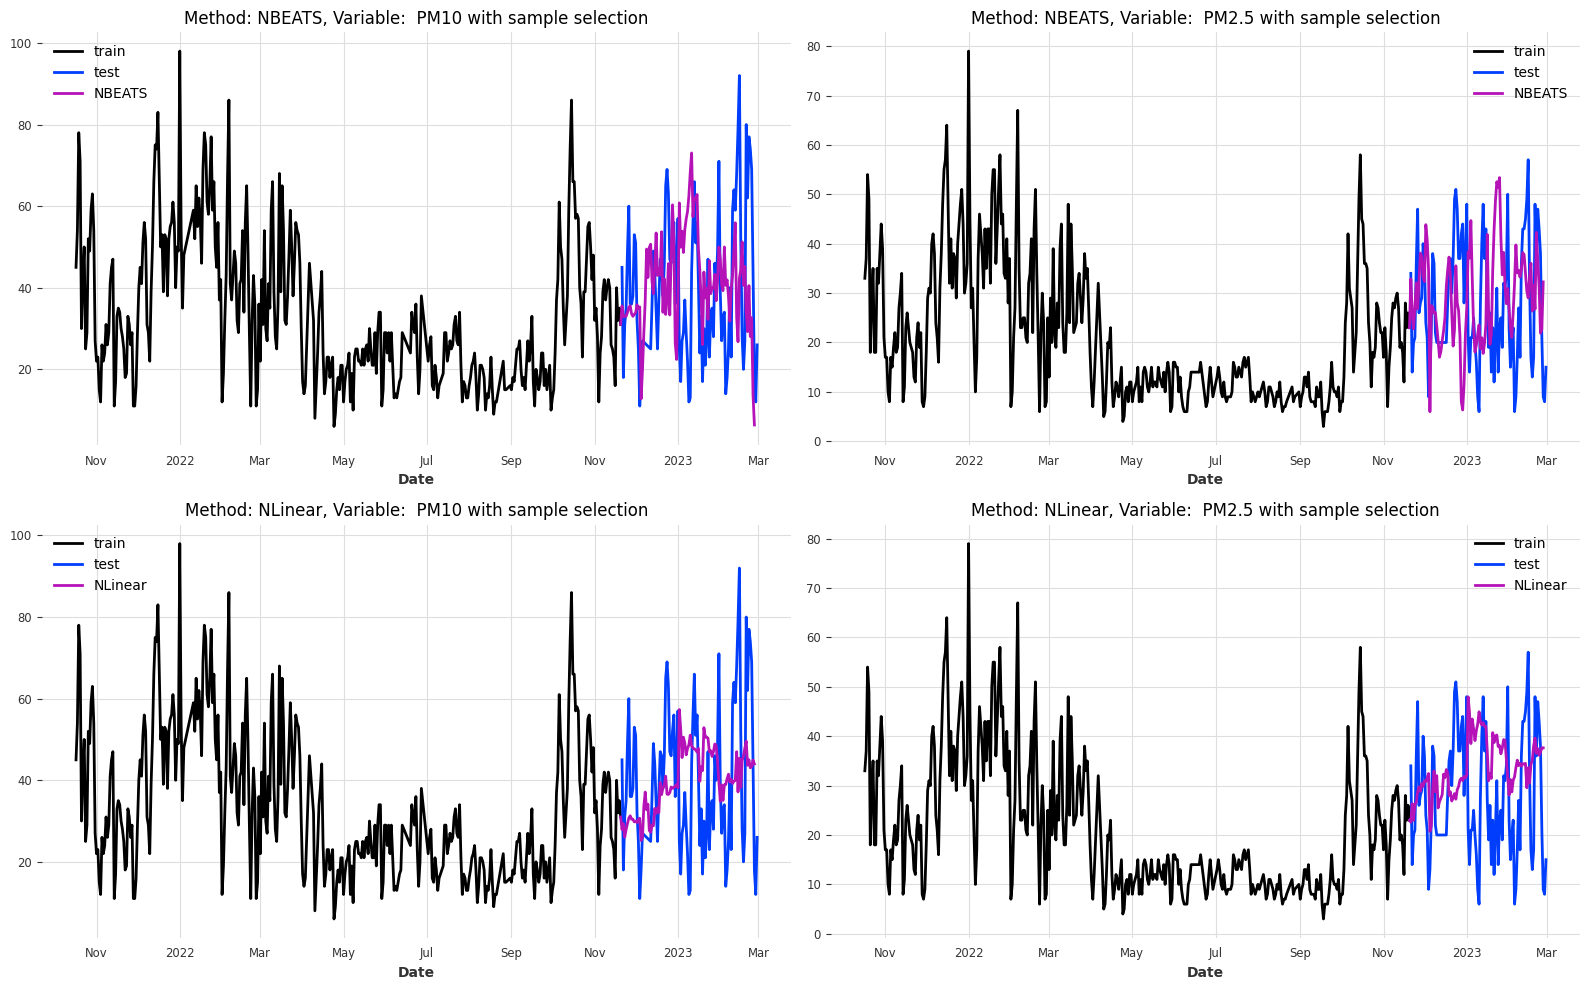

In [49]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 14))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    predictions = tmp_train[-1]
    # devo scorrere test a botte da 12 e aggiungerli a tmp_train
    for pred in range(0, 98, 14):
      model.fit(series=tmp_train)
      prediction = model.predict(n = 14, series=tmp_train)
      predictions = predictions.append(prediction)
      pred = tmp_test.get_timestamp_at_point(pred)
      tmp_add = tmp_test.slice_n_points_after(pred, 14)
      tmp_train = tmp_train.append(tmp_add)
    mae_score = round(mae(tmp_test, predictions), 5)
    mae_list.append([mae_score, name, 'std'])
    mse_score = round(mse(tmp_test, predictions), 5)
    mse_list.append([mse_score, name, 'std'])
    index += i + row
    fig.add_subplot(2, 2, index) # method, variable, position
    tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
fig.tight_layout()
plt.savefig('nn_wo.png')
plt.show()

fig = plt.figure(figsize=(16, 10))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    predictions = tmp_train[-1]
    for pred in range(0, 98, 14):
      model.fit(series = lst_series)
      prediction = model.predict(n = 14, series = tmp_train)
      predictions = predictions.append(prediction)
      pred = tmp_test.get_timestamp_at_point(pred)
      tmp_add = tmp_test.slice_n_points_after(pred, 14)
      lst_series.append(tmp_add)
      tmp_train = tmp_train.append(tmp_add)
    if column == ' PM10':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'PM10'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'PM10'])
    elif column == ' PM2.5':
      mae_score = round(mae(tmp_test, predictions), 5)
      mae_list.append([mae_score, name, 'PM25'])
      mse_score = round(mse(tmp_test, predictions), 5)
      mse_list.append([mse_score, name, 'PM25'])

    index += i + row
    fig.add_subplot(2, 2, index)
    train.univariate_component(column).plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('nn_w.png')
plt.show()

In [ ]:
print(mae_list)
print(mse_list)

### BACKTEST    

Backtest first try

In [ ]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(18, 14))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    tmp_series = series.univariate_component(column)
    tmp_train = train.univariate_component(column)
    tmp_test = test.univariate_component(column)
    # Get predictions
    prediction = model.historical_forecasts(series=tmp_series,
                                              start=len(tmp_train),
                                              forecast_horizon=len(tmp_test),
                                              stride=1,
                                              retrain=True,
                                              last_points_only=False,
                                              overlap_end=True)

    predictions = concatenate(prediction[0], ignore_time_axis=True)
    print(len(tmp_test))
    print(len(predictions))
    # Calculate MAE and MSE
    mae_score = round(mae(tmp_test, predictions), 5)
    mae_list.append([mae_score, name, 'std'])
    mse_score = round(mse(tmp_test, predictions), 5)
    mse_list.append([mse_score, name, 'std'])
    index += i + row
    fig.add_subplot(2, 2, index) # method, variable, position
    tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
fig.tight_layout()
plt.savefig('nn_wo.png')
plt.show()

fig = plt.figure(figsize=(16, 10))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    if column == ' PM10':
      tmp_series = series_10.univariate_component(column)
      forecast_len = len(series)-len(train_10)
      prediction = model.historical_forecasts(series=tmp_series,
                                                start = len(train_10),
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      tmp_series = series.univariate_component(column)
      start = len(train_10)
      end = start + len(test)
      mae_score = round(mae(tmp_series[start:end], predictions), 5)
      mae_list.append([mae_score, name, 'PM10'])
      mse_score = round(mse(tmp_series[start:end], predictions), 5)
      mse_list.append([mse_score, name, 'PM10'])
    elif column == ' PM2.5':
      tmp_series = series_25.univariate_component(column)
      forecast_len = len(series)-len(train_25)
      prediction = model.historical_forecasts(series=tmp_series,
                                                start = len(train_25),
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      tmp_series = series.univariate_component(column)
      start = len(train_25)
      end = start + len(test)
      mae_score = round(mae(tmp_series[start:end], predictions), 5)
      mae_list.append([mae_score, name, 'PM25'])
      mse_score = round(mse(tmp_series[start:end], predictions), 5)
      mse_list.append([mse_score, name, 'PM25'])

    index += i + row
    fig.add_subplot(2, 2, index)
    train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('nn_w.png')
plt.show()

In [ ]:
print(mae_list)
print(mse_list)

Backtest second try

In [ ]:
# mae_list = []
# mse_list = []
# fig = plt.figure(figsize=(18, 14))
# row = 0
# for i, (name, model) in enumerate(models.items()):
#   print(name)
#   row += 1
#   for index, column in enumerate(header):
#     tmp_series = series.univariate_component(column)
#     tmp_train = train.univariate_component(column)
#     tmp_test = test.univariate_component(column)
#     # Get predictions
#     prediction = model.historical_forecasts(series=tmp_series,
#                                               start=len(tmp_train),
#                                               forecast_horizon=len(tmp_test),
#                                               stride=1,
#                                               retrain=True,
#                                               last_points_only=False,
#                                               overlap_end=True)

#     predictions = concatenate(prediction[0], ignore_time_axis=True)
#     print(len(tmp_test))
#     print(len(predictions))
#     # Calculate MAE and MSE
#     mae_score = round(mae(tmp_test, predictions), 5)
#     mae_list.append([mae_score, name, 'std'])
#     mse_score = round(mse(tmp_test, predictions), 5)
#     mse_list.append([mse_score, name, 'std'])
#     index += i + row
#     fig.add_subplot(2, 2, index) # method, variable, position
#     tmp_train.plot(label="train"); tmp_test.plot(label="test"); predictions.plot(label=name)
#     plt.title(f"Method: {name}, Variable: {column} (std)"); plt.legend()
# fig.tight_layout()
# plt.savefig('nn_wo.png')
# plt.show()

fig = plt.figure(figsize=(16, 10))
row = 0
for i, (name, model) in enumerate(models.items()):
  print(name)
  row += 1
  for index, column in enumerate(header):
    if column == ' PM10':
      tmp_series = series_10.univariate_component(column)
      forecast_len = len(series)-len(train_10)
      prediction = model.historical_forecasts(series=lst_series,
                                                start = 0,
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      tmp_series = series.univariate_component(column)
      start = len(train_10)
      end = start + len(test)
      mae_score = round(mae(tmp_series[start:end], predictions), 5)
      mae_list.append([mae_score, name, 'PM10'])
      mse_score = round(mse(tmp_series[start:end], predictions), 5)
      mse_list.append([mse_score, name, 'PM10'])
    elif column == ' PM2.5':
      tmp_series = series_25.univariate_component(column)
      forecast_len = len(series)-len(train_25)
      prediction = model.historical_forecasts(series=tmp_series,
                                                start = len(train_25),
                                                forecast_horizon = forecast_len,
                                                stride = 1,
                                                retrain=True,
                                                last_points_only=False,
                                                overlap_end=True)
      
      predictions = concatenate(prediction[0], ignore_time_axis=True)
      print(len(predictions))
      tmp_series = series.univariate_component(column)
      start = len(train_25)
      end = start + len(test)
      mae_score = round(mae(tmp_series[start:end], predictions), 5)
      mae_list.append([mae_score, name, 'PM25'])
      mse_score = round(mse(tmp_series[start:end], predictions), 5)
      mse_list.append([mse_score, name, 'PM25'])

    index += i + row
    fig.add_subplot(2, 2, index)
    train.univariate_component(column).plot(label="train"); test.univariate_component(column).plot(label="test"); predictions.plot(label=name)
    plt.title(f"Method: {name}, Variable: {column} with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('nn_w.png')
plt.show()